# CellRank meets RNA velocity

In this tutorial, you will learn how to...
- use <cite data-cite="bergen:20">scVelo</cite> to compute <cite data-cite="manno:18">RNA velocity</cite>, see the [scVelo docs](https://scvelo.readthedocs.io/) to learn more. 
- set up CellRank's `VelocityKernel` and compute a transition matrix based on RNA velocity. 
- combine the `VelocityKernel` with the `ConnectivityKernel` to emphasize gene expression similarity. 
- visualize the transition matrix in a low-dimensional embedding. 

To demonstrate this, we will use a scRNA-seq dataset of <cite data-cite="bastidas-ponce:19">pancreas development at embyonic day E15.5</cite>. If you want to run this on your own data, you will need...
- a scRNA-seq dataset which has been preprocessed to contain unspliced & spliced counts using a software like the [velocyto command line tool](http://velocyto.org/velocyto.py/tutorial/index.html#running-the-cli). 

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/cellrank_meets_rna_velocity.ipynb).

## Import packages & data

Check whether we are on google collab. 

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev
    !pip install python-igraph

Import packages, set verbosity levels. 

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

Filter some warnings. 

In [5]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

First, we need to get the data. The following commands downloads the `adata` object and saves it under `datasets/endocrinogenesis_day15.5.h5ad`. We visualize the fraction of spliced/unspliced reads; these are required to estimate RNA velocity. 

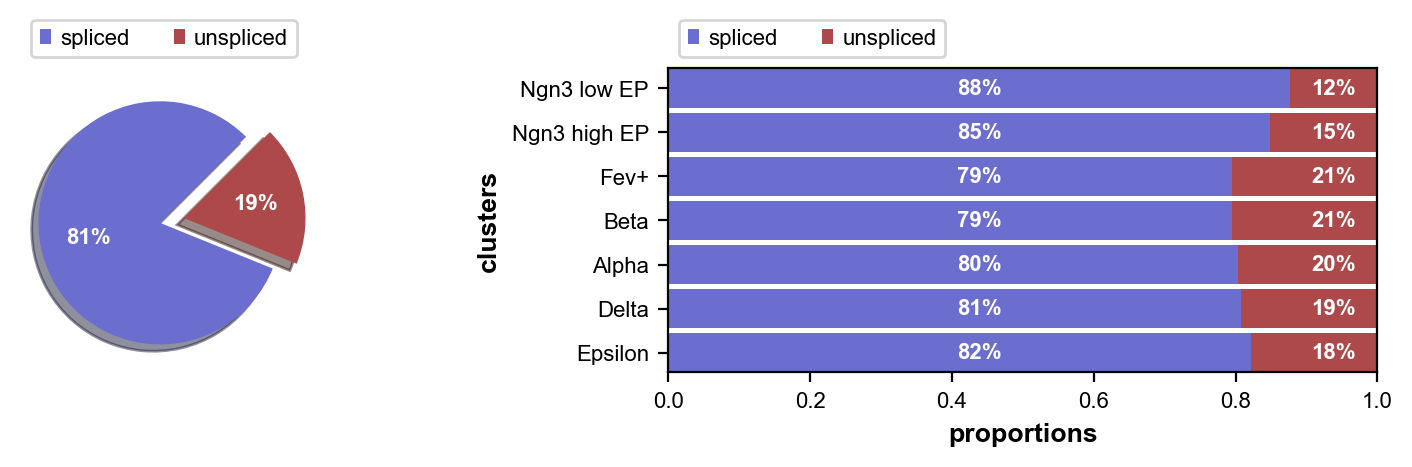

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [6]:
adata = cr.datasets.pancreas()
scv.pl.proportions(adata)
adata

## Pre-process the data

Filter out genes which don't have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. Further, compute principal components and moments for velocity estimation. These are standard scanpy/scvelo functions, for more information about them, see the [scVelo API](https://scvelo.readthedocs.io/api.html#preprocessing-pp).

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Run scVelo

We will use the [dynamical model](https://scvelo.readthedocs.io/DynamicalModeling.html) from scVelo to estimate the velocities. Please make sure to have at least version `0.2.3` of scVelo installed to make use **parallelisation** in `scv.tl.recover_dynamics`. On my laptop, using 8 cores, the below cell takes about 1:30 min to execute. 

In [8]:
scv.tl.recover_dynamics(adata, n_jobs=8)

recovering dynamics (using 8/8 cores)



    finished (0:01:41) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Once we have the parameters, we can use these to compute the actual velocities. 

In [9]:
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)



    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


We'll use CellRank to visualize the velocities in an embedding further down below. 

## Set up the `VelocityKernel`

Set up the `VelocityKernel` from the `adata` object containing the scVelo-computed velocities. 

In [14]:
vk = cr.kernels.VelocityKernel(adata)

Use the `VelocityKernel` to compute a transition matrix by correlating each cell's velocity vector with the displacement vectors towards nearest neighbors, directly in high-dimensional gene expression space. 

In [17]:
vk.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


Using `softmax_scale=3.9741`


    Finish (0:00:03)


VelocityKernel

By default, we use the `deterministic` mode to compute the transiton matrix. If you want to propagate uncertainty in the velocity vectors, check out the `stochastic` and `monte_carlo` modes. 

## Combine with the `ConnectivityKernel`

Next, let's explore ways to visualize the computed transition matrix. 

## Visualize the transition matrix 

Similar to <cite cite-data="bergen:20">scVelo</cite> and <cite cite-data="manno:18">velocyto</cite>, CellRank visualizes the transition matrix in any low dimensional embedding (UMAP, t-SNE, PCA, Diffmap, etc.) via arrows or streamlines. 

Using precomputed projection `adata.obsm['T_fwd_umap']`


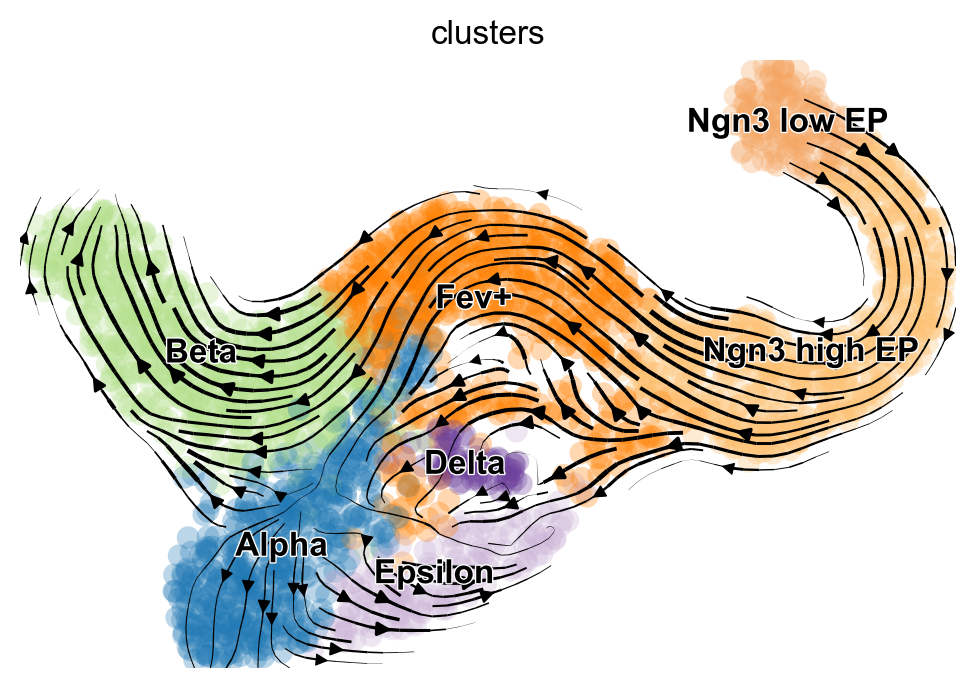

In [18]:
vk.plot_projection()

As shown before in the <cite data-cite="bergen:20">scVelo publication</cite>, the projected velocity vectors capture the overall trend in this system: *Neurogenin 3* low endocrine progenitor cells (Ngn3 low EP) gradually transition via indermediate stages towards terminal, hormone producing Alpha, Beta, Epsilon and Delta cells. Another way to visualize this is via random walks: 

Simulating `100` random walks of maximum length `633`


    Finish (0:00:07)
Plotting random walks


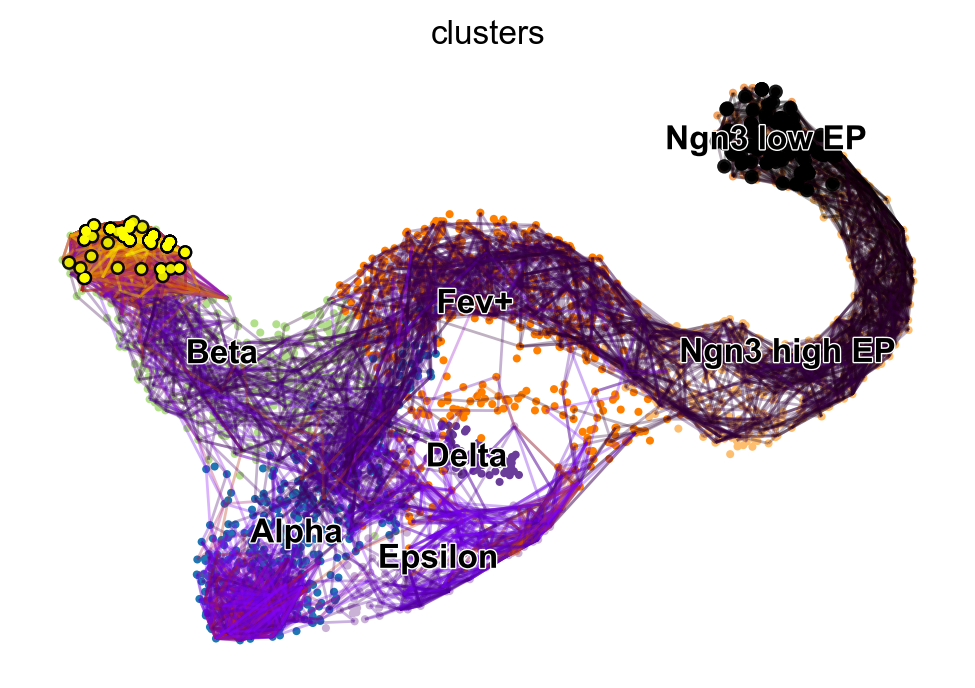

In [20]:
vk.plot_random_walks(start_ixs={'clusters':'Ngn3 low EP'})

We simulated 100 random walks, each of length 632 (that is `n_cells * max_iter = 2531 * 0.25 = 632.75`), which start in the `Ngn3 low EP` cluster. Black (yellow) dots denote the start (end) of a random walk. In agreement with <cite data-cite="bastidas-ponce:19">known biology</cite>, the Beta cluster is dominant at E15.5. 

## What's next? 

In this tutorial, you learned how to use CellRank to compute a transition matrix using RNA velocity and gene expression similarity and how it can be visualized in low dimensions. The real power of CellRank comes in when you use estimators to analyze the transition matrix directly, rather than projecting it. For the next steps, we recommend...
- to go through the XXX tutorial

## Package versions

We used the following package versions to generate this tutorial: 

In [22]:
cr.logging.print_versions()

cellrank==1.5.1+g65f1562 scanpy==1.7.2 anndata==0.8.0 numpy==1.21.4 numba==0.51.2 scipy==1.5.3 pandas==1.3.3 pygpcca==1.0.2 scikit-learn==0.24.0 statsmodels==0.12.1 python-igraph==0.8.3 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.3.3 seaborn==0.11.0
